In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
import numpy as np
import random
# import matplotlib.pyplot as plt
# import PIL
from PIL import ImageOps
from IPython.display import display

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [20]:
IMG_SIZE = 512, 512
IMG_SIZE_BACKBONE = 512, 512  # 224, 224
NUM_CLASSES = 4
BATCH_SIZE = 10
FILTERS = [32, 64, 128, 256]
CLASS_WEIGHTS = [0.587, 9.84, 0.474, 11.42]

In [5]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)

In [6]:
# meanIoU = tf.keras.metrics.MeanIoU(NUM_CLASSES, dtype=None)
path_to_images = '<path to images>'
path_to_targets = '<path to masks>'

In [7]:
input_img_paths = sorted(
    [
        os.path.join(path_to_images, fname)
        for fname in os.listdir(path_to_images)
        if fname.endswith((".JPG", ".png"))
    ]
)

target_img_paths = sorted(
    [
        os.path.join(path_to_targets, fname)
        for fname in os.listdir(path_to_targets)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [8]:
class CustomDataset(tf.keras.utils.Sequence):

    """Helper to create datasets"""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, class_weights):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.class_weights = tf.constant(class_weights)
        

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, interpolation='nearest')
            x[j] = img
            x[j] /= 255
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='int32')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale", interpolation='nearest')
            y[j] = np.expand_dims(img, 2)
            
        sample_weights = tf.gather(self.class_weights, indices=tf.cast(y, 'int32'))
        return x, y, sample_weights

In [9]:
train_samples = 180
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:train_samples]
train_target_img_paths = target_img_paths[:train_samples]
val_input_img_paths = input_img_paths[train_samples:]
val_target_img_paths = target_img_paths[train_samples:]

In [10]:
# Instantiate data Sequences for each split
train_gen = CustomDataset(
                    BATCH_SIZE,
                    IMG_SIZE,
                    train_input_img_paths,
                    train_target_img_paths,
                    CLASS_WEIGHTS
            )
            
val_gen = CustomDataset(
                    BATCH_SIZE,
                    IMG_SIZE,
                    val_input_img_paths,
                    val_target_img_paths,
                    CLASS_WEIGHTS
            )

In [11]:
def get_segmented_image(my_model, image_paths=input_img_paths):

    '''Helper to test model predictions'''

    random_image = random.choice(image_paths)
    random_image = load_img(random_image, target_size=IMG_SIZE)
    img_arr = img_to_array(random_image)
    img_arr /= 255
    img_arr_exp = tf.expand_dims(img_arr, 0)
    preds = my_model.predict(img_arr_exp)
    mask = np.argmax(preds, axis=-1)
    mask = tf.squeeze(mask)
    mask_red = np.where(mask == 1, 255, 0)
    mask_green = np.zeros(shape=(mask.shape))
    mask_blue = np.where(mask == 2, 255, 0)
    stacked_mask = np.stack((mask_red, mask_green, mask_blue), axis=2)
    superimposed_img = random_image + stacked_mask
    print(superimposed_img.shape)
    
    
    return array_to_img(superimposed_img)

In [12]:
def create_encoder(inputs, filters_list, size=3, apply_dropout=False):

  encoder_outputs = []
  init_inputs = inputs  
  # initializer = tf.random_normal_initializer(0., 0.02)

  for filters in filters_list:

    x = layers.SeparableConv2D(filters,
                               size,
                               padding='same',
                               # kernel_initializer=initializer,
                               use_bias=False)(inputs)
    if apply_dropout:
      x = layers.Dropout(0.5)(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.SeparableConv2D(filters,
                               size,
                               padding='same',
                               # kernel_initializer=initializer,
                               use_bias=False)(x)                           
    x= layers.MaxPooling2D(3, strides=2, padding="same")(x)
    if apply_dropout:
      x = layers.Dropout(0.5)(x)
    x = layers.ReLU(name=f'activation_{filters}')(x)
    x = layers.BatchNormalization()(x)  

    encoder_outputs.append(x)
    inputs = x

  return tf.keras.Model(inputs=init_inputs, outputs=encoder_outputs)

In [13]:
def get_decode_layer(filters, size=3, apply_dropout=False):
  
  # initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, size,
                                              padding='same',
                                              # kernel_initializer=initializer,
                                              use_bias=False))
  result.add(layers.Conv2DTranspose(filters, size,
                                            padding='same',
                                            # kernel_initializer=initializer,
                                            use_bias=False))

  result.add(layers.UpSampling2D(2))
  result.add(layers.ReLU())
  result.add(layers.BatchNormalization())                                         
  if apply_dropout:
    result.add(layers.Dropout(0.5))  

  return result

In [14]:
def get_unet(input_shape, filters_list, output_channels:int, activation:str):

    inputs = layers.Input(shape=input_shape + (3,))

    layer_names = [f'activation_{filters}' for filters in filters_list]

    # encoder part of the model
    encoder = create_encoder(inputs, filters_list)
    # get encoder_outputs
    skips = [encoder.get_layer(name).output for name in layer_names]
    # decoder part of the model
    decoding_layers = [get_decode_layer(filters) for filters in filters_list[::-1]]

    x = skips[-1]
    # reverse order!
    skips = skips[-2::-1]

    # Upsampling and establishing the skip connections
    for up_layer, skip in zip(decoding_layers[:-1], skips):
        x = up_layer(x)
        concat = layers.Concatenate()
        x = concat([x, skip])

    x = decoding_layers[-1](x)
    # last layer of the model
    last_layer = layers.Conv2D(filters=output_channels, kernel_size=1,
                                            padding='same',
                                            activation=activation
                                        ) 

    x = last_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [21]:
# callback_01 = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=PATIENCE,
#     verbose=1,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )

callback_02 = tf.keras.callbacks.ModelCheckpoint(
    './sem_seg_model_backbone_4cl',
    monitor="val_loss",
    mode = 'min',
    save_best_only=True,
)

In [16]:
unet_model = get_unet(
    IMG_SIZE,
    FILTERS,
    NUM_CLASSES,
    activation='softmax'
)

In [17]:
# unet_model.summary()

In [18]:
unet_model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), MyMeanIOU(NUM_CLASSES) ]
        )

In [1]:
epochs = 100
unet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[callback_02]
)

In [33]:
unet_model.save('<model save path>')
# loaded_model = tf.keras.models.load_model('./vanilla_unet_model')

INFO:tensorflow:Assets written to: vanilla_unet_model/assets


#### Test the model

In [21]:
def get_segmented_image(my_model, img_size, image_paths=input_img_paths):

    random_image = random.choice(image_paths)
    random_image = load_img(random_image, target_size=img_size)
    img_arr = img_to_array(random_image)
    img_arr /= 255
    img_arr_exp = tf.expand_dims(img_arr, 0)
    preds = my_model.predict(img_arr_exp)
    mask = np.argmax(preds, axis=-1)
    mask = tf.squeeze(mask)
    mask_red = np.where(mask == 1, 255, 0)
    mask_green = np.zeros(shape=(mask.shape))
    mask_blue = np.where(mask == 2, 255, 0)
    stacked_mask = np.stack((mask_red, mask_green, mask_blue), axis=2)
    superimposed_img = random_image + stacked_mask    
    
    return array_to_img(superimposed_img)

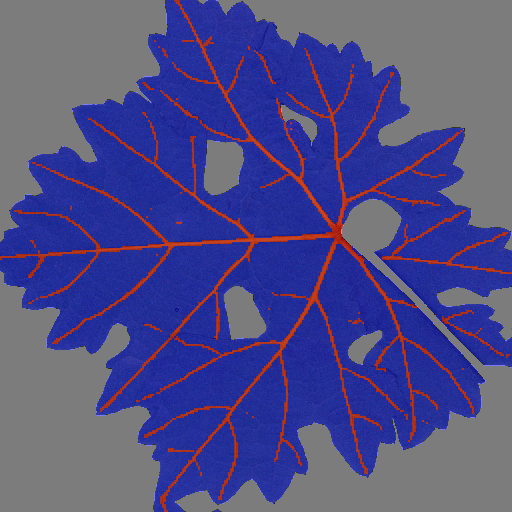

In [24]:
get_segmented_image(unet_model, IMG_SIZE)

### Same model with backbone

In [22]:
backbone_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE_BACKBONE + (3,),
        include_top=False
    )

In [23]:
def get_unet_model_with_backbone(output_channels:int):

  inputs = tf.keras.layers.Input(shape=(IMG_SIZE_BACKBONE)+ (3,))

  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   
      'block_3_expand_relu',   
      'block_6_expand_relu',   
      'block_13_expand_relu',  
      'block_16_project',      
  ]

  backbone_model_outputs = [backbone_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  encoder = tf.keras.Model(inputs=backbone_model.input, outputs=backbone_model_outputs)

  encoder.trainable = False

  up_stack = [get_decode_layer(filters) for filters in (512, 256, 128, 64)]

  # Downsampling through the model
  skips = encoder(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
                                filters=output_channels,
                                kernel_size=3,
                                strides=2,
                                padding='same',
                                activation='softmax') 

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
unet_backbone = get_unet_model_with_backbone(NUM_CLASSES)

In [25]:
unet_backbone.compile(
            optimizer='rmsprop',
            loss="sparse_categorical_crossentropy",
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), MyMeanIOU(NUM_CLASSES) ]
    )

In [26]:
# Instantiate data Sequences for each split
train_gen_backbone = CustomDataset(
                    BATCH_SIZE,
                    IMG_SIZE_BACKBONE,
                    train_input_img_paths,
                    train_target_img_paths,
                    CLASS_WEIGHTS
            )
            
val_gen_backbone = CustomDataset(
                    BATCH_SIZE,
                    IMG_SIZE_BACKBONE,
                    val_input_img_paths,
                    val_target_img_paths,
                    CLASS_WEIGHTS
            )

In [2]:
epochs = 100
unet_backbone.fit(
    train_gen_backbone,
    validation_data=val_gen_backbone,
    epochs=epochs,
    callbacks=[callback_02]
)

(224, 224, 3)


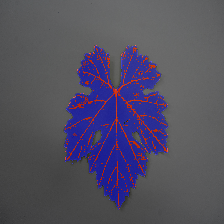

In [41]:
get_segmented_image(unet_backbone, IMG_SIZE_BACKBONE)

In [28]:
def get_segmented_image_4cl(my_model, img_size, image_paths=input_img_paths):

    random_image = random.choice(image_paths)
    random_image = load_img(random_image, target_size=img_size)
    img_arr = img_to_array(random_image)
    img_arr /= 255
    img_arr_exp = tf.expand_dims(img_arr, 0)
    preds = my_model.predict(img_arr_exp)
    mask = np.argmax(preds, axis=-1)
    mask = tf.squeeze(mask)
    mask_red = np.where(mask == 1, 255, 0)
    mask_green = np.where(mask == 3, 255, 0)
    # mask_green = np.zeros(shape=(mask.shape))
    mask_blue = np.where(mask == 2, 255, 0)
    stacked_mask = np.stack((mask_red, mask_green, mask_blue), axis=2)
    superimposed_img = random_image + stacked_mask    
    
    return array_to_img(superimposed_img)

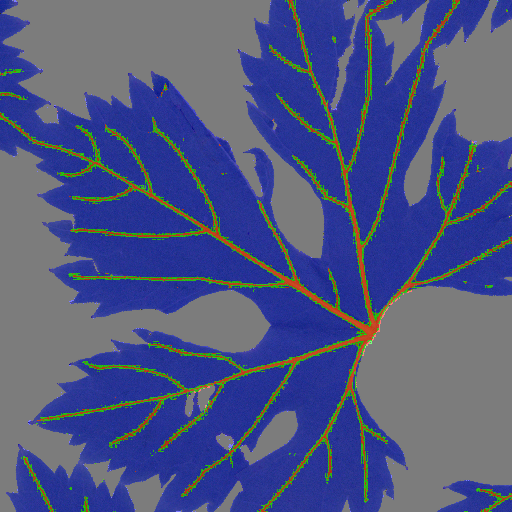

In [29]:
get_segmented_image_4cl(unet_backbone, IMG_SIZE)